# Сделать три сети для сегментации CityScapes

1.Обучить на базе датасета с улицами три нейросети: линейную, U-Net (или U-Net Plus) и PSPNet   

Сравните результаты, в выводах напишите, какая сеть оказалась точнее   

*Для того, чтобы исследование было честным, я буду обучать НС на одинаковых данных и одинаковом кол. эпох.

In [1]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями

from google.colab import drive # Подключаем диск Google

import matplotlib.pyplot as plt # Библиотека для рисования
%matplotlib inline

In [2]:
# Подключаем свой диск Google
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
# Загрузка датасета с улицами 
!unzip /content/drive/MyDrive/Colab\ Notebooks/Machine_learning/Datasets/cityscapes.zip -d /content/

In [ ]:
# Исходные изображения в датасете имеют размер 512 Х 256
# Каждое изображение это и x и y (т.е. и вопрос и результат сегментации)
# Деля изображение на 2 получим изображения 256 на 256
# Авторы датасета сжали изображения к квадратам. Изначально они были в формате 3 Х 4.
# Поэтому необходимо произвести расширение

# width_original  = 352 # ширина картинки без сжатия
# height_original = 256 # высота картинки без сжатия

# 3 - 256
# 4 - х
# Вычислим новую ширину используя пропорцию
# x = 4*256/3 = 341,(3)

# Предполагаем, что будем уменьшать изображение 4 раза (4 блока)
# Поэтому размеры изображения без сжатия необходимо 4 раза делить на 2.
'''
341,(3) / 2 / 2 / 2 / 2 = 21,(3)
# Округляем до 22, чтобы было чётное
Далее умножаем на 2 столько раз, сколько блоков задумали.
22 * 2 * 2 * 2 * 2 = 352 - новая ширина
'''


# Переводим в новый размер
width = 352
height = 256

dataset = '/content/cityscapes/'    # Путь к датасету
dataset_train = dataset + "/train"  # Путь к обучающей выборке
dataset_val   = dataset + "/val"    # Путь к провероной выборке

num_classes = 8 # Количество классов на изображении

# На сколько классов сегментировали изображения авторы датасета
# 1  - желтый - дорожные знаки
# 2  - серый - здания
# 3  - светло-серый - столбы
# 4  - синий - машины
# 5  - бирюзовый - автобусы
# 6  - черный - оветительные приборы, баннеры и др.
# 7  - голубой - небо
# 8  - фиолетовый - проезжая часть
# 9  - розовый - пешеходные зоны
# 10 - темно-фиолетовый - парковки
# 11 - светло-фиолетовый - клумбы, тумбы и т.д.
# 12 - зеленый - деревья, кустарник
# 13 - салатовый - трава
# 14 - краный - люди
# 15 - бордовый - велосипеды
# 16 - оранжевый - светофоры
# 17 - коричневый - заборы

# Для себя мы выберем (На сколько классов будем сегментировать):
# 1 - черный     - разное
# 2 - голубой    - небо
# 3 - красный    - велосипеды + люди
# 4 - серый      - здания + тумбы + заборы
# 5 - зеленый    - трава или деревья
# 6 - желтый     - дорожные знаки + светофоры
# 7 - синий      - машины + автобусы
# 8 - фиолетовый - проезжая часть
# 9 - розовый    - пешеходные зоны + парковки

In [ ]:
# Функции загрузки датасета

# Функция разделения одной картинки на две - xTrain и yTrain
def separate_train(name):
    image = Image.open(name)

    x = image.crop((0, 0, 255, 255)).resize((width, height), Image.ANTIALIAS)
    y = image.crop((256, 0, 511, 255)).resize((width, height), Image.ANTIALIAS)

    return x, y

# Функция сегментации пикселей.
# Выдаёт индекс класса и цвет его сегментации для каждого полученного пикселя
def pixel_segmentation(pixel):
    index = 0
    color = [0, 0, 0]

    if (110>=pixel[0]>=50) and (150>=pixel[1]>=115) and (190>=pixel[2]>=160):  # небо
        index = 0
        color = [70, 130, 180]

    elif (157>=pixel[0]>=109) and (42>=pixel[1]>=0) and (72>=pixel[2]>=34): # велосипеды
        index = 1 # велосипеды + люди
        color = [255, 0, 0]
    elif (255>=pixel[0]>=185) and (50>=pixel[1]>=0) and (86>=pixel[2]>=0): # люди
        index = 1 # велосипеды + люди
        color = [255, 0, 0]
    
    elif (80>=pixel[0]>=60) and (80>=pixel[1]>=60) and (80>=pixel[2]>=60): # здания
        index = 2 # здания + тумбы + заборы
        color = [70, 70, 70]
    elif (115>=pixel[0]>=95) and (110>=pixel[1]>=90) and (170>=pixel[2]>=150): # тумбы
        index = 2 # здания + тумбы + заборы
        color = [70, 70, 70]
    elif (200>=pixel[0]>=180) and (160>=pixel[1]>=140) and (160>=pixel[2]>=140): # заборы
        index = 2 # здания + тумбы + заборы
        color = [70, 70, 70]
    
    elif (190>=pixel[0]>=120) and (255>=pixel[1]>=240) and (185>=pixel[2]>=115): # трава
        index = 3 # трава и деревья
        color = [120, 145, 20]
    elif (120>=pixel[0]>=60) and (160>=pixel[1]>=110) and (70>=pixel[2]>=20): # деревья
        index = 3 # трава и деревья
        color = [120, 145, 20]

    elif (235>=pixel[0]>=160) and (230>=pixel[1]>=200) and (135>=pixel[2]>=0): # дорожные знаки
        index = 4 # дорожные знаки и светофоры
        color = [250, 250, 0]
    elif (255>=pixel[0]>=140) and (180>=pixel[1]>=143) and (80>=pixel[2]>=0): # светофоры
        index = 4 # дорожные знаки и светофоры
        color = [250, 250, 0]

    elif (30>=pixel[0]>=0) and (30>=pixel[1]>=0) and (255>=pixel[2]>=125): # машины
        index = 5 # машины и автобусы
        color = [20, 20, 255]
    elif (30>=pixel[0]>=0) and (80>=pixel[1]>=40) and (120>=pixel[2]>=0): # автобусы
        index = 5 # машины и автобусы
        color = [20, 20, 255]

    elif (160>=pixel[0]>=105) and (75>=pixel[1]>=55) and (150>=pixel[2]>=120): # проезжая часть
        index = 6 # проезжая часть
        color = [130, 65, 128]

    elif (255>=pixel[0]>=210) and (70>=pixel[1]>=25) and (255>=pixel[2]>=200): # пешеходные зоны
        index = 7 # пешеходные зоны и парковки
        color = [220, 180, 200]
    elif (255>=pixel[0]>=240) and (180>=pixel[1]>=150) and (220>=pixel[2]>=150): # парковки
        index = 7 # пешеходные зоны и парковки
        color = [220, 180, 200]

    return color, index


# Функция распределения изображения по классам
def segmentation_transform(img_obj):
    img_original = np.array(img_obj) # преобразовываем изображение в массив
    img_seg = img_original.copy() # создаем массив для нашей модели сегментации
    y = np.zeros((height, width, num_classes)) # создаем yTrain

    for w in range(width):
        for h in range(height):
            img_seg[h,w], ind = pixel_segmentation(img_original[h,w])
            y[h,w] = utils.to_categorical(ind, num_classes)

    return Image.fromarray(img_seg), y # Мы должны обратно из массива перевести в объект картинка

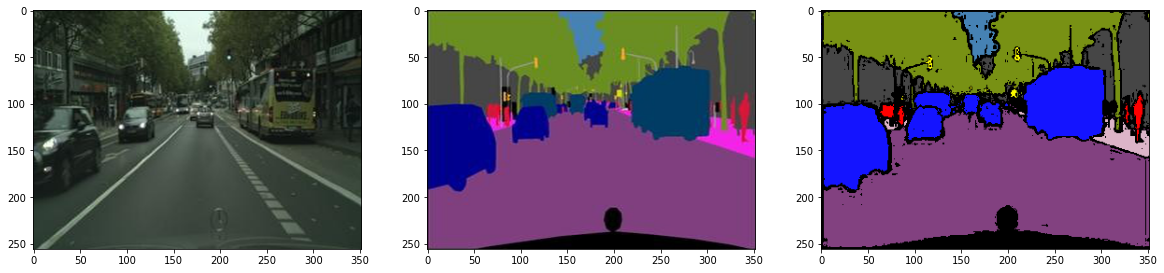

In [ ]:
# Посмотрим на изображение

x, z = separate_train(dataset_train+"/13.jpg") # загружаем, разделяем и выравниваем геометрию
y, yt = segmentation_transform(z)

#print(x.format, x.size, x.mode)
#print(y.format, y.size, y.mode)
#print(yt.shape, yt[0:5])

fig, axs = plt.subplots(1, 3, figsize=(20, 10)) # Создаем полотно нужной размерности
axs[0].imshow(x) # Отображаем самолет
axs[1].imshow(z) # Отображаем маску
axs[2].imshow(y) # Отображаем маску

plt.show() # Показываем изображения

## Формирование выборок путём преобразования изображений в NumPy массивы с сохранением в файлы.   
Занимает уйму времени

In [ ]:
# # Формируем обучающую выборку
# # Преобразует изображения в представление numpy массивов.
# # Которые сохраняются в файлы. При обучении НС эти файлы будут быстрее обрабатываться.
# xTrain = []
# yTrain = []

# cur_time = time.time() # Получаем текущю метку времени
# flist = os.listdir(dataset_train)
# c = 1
# for filename in sorted(os.listdir(dataset_train)): # Получаем список файлов
#   print(c, "из", len(flist))
#   # Загружаем картинку, сразу же приводим её к нужным размерам и добавляем в массив
#   x, z = separate_train(dataset_train+"/"+filename) # получаем исходное изображение и сегментированное
#   _, yt = segmentation_transform(z) # сегментированное изображение переводим в OHE
#   xTrain.append(np.array(x))
#   yTrain.append(yt)
#   c += 1

# xTrain = np.array(xTrain)
# yTrain = np.array(yTrain)
# finish_time = time.time()
# print ('Время загрузки изображений тренировочной:', finish_time - cur_time, 'c')

# f_x = open('/content/drive/MyDrive/ITHub/ML/xTrain.npy', 'wb')
# f_y = open('/content/drive/MyDrive/ITHub/ML/yTrain.npy', 'wb')

# np.save(f_x, xTrain)
# np.save(f_y, yTrain)

In [ ]:
# print(xTrain.shape)
# print(yTrain.shape)

In [ ]:
# # Формируем проверочную выборку
# xVal = []
# yVal = []

# cur_time = time.time() # Получаем текущю метку времени
# flist = os.listdir(dataset_val)
# c = 1
# for filename in sorted(flist): # Получаем список файлов
#   print(c, "из", len(flist))
#   # Загружаем картинку, сразу же приводим её к нужным размерам и добавляем в массив
#   x, z = separate_train(dataset_val+"/"+filename) # получаем исходное изображение и сегментированное
#   _, yt = segmentation_transform(z) # сегментированное изображение переводим в OHE
#   xVal.append(np.array(x))
#   yVal.append(yt)
#   c += 1

# xVal = np.array(xVal)
# yVal = np.array(yVal)

# finish_time = time.time()
# print ('Время загрузки изображений проверочной выборки:', finish_time - cur_time, 'c')

# f_x = open('/content/drive/MyDrive/ITHub/ML/xVal.npy', 'wb')
# f_y = open('/content/drive/MyDrive/ITHub/ML/yVal.npy', 'wb')

# np.save(f_x, xVal)
# np.save(f_y, yVal)

In [ ]:
# print(xVal.shape)
# print(yVal.shape)

## Загрузка сформированных выборок-файлов NumPy
Сформированные выборки-файлы много весят.   
Их придётся подгружать с GD в виде архива  


In [ ]:
# Загрузка архива сформированных выборок-файлов NumPy
!unzip /content/drive/MyDrive/Colab\ Notebooks/Machine_learning/Datasets/cityscapes_Val.zip -d /content/

Archive:  /content/drive/MyDrive/Colab Notebooks/Machine_learning/Datasets/cityscapes_Val.zip
  inflating: /content/xVal.npy       
  inflating: /content/yVal.npy       


In [ ]:
# Загружу валидационные данные как данные для обучения и возьму от них кусочек для валидации.
# Это позволит быстро обучить НС на малом числе данных
xTrain = np.load('/content/xVal.npy')
yTrain = np.load('/content/yVal.npy')

# Разделим наши выборки на обучающую и проверочную
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain, test_size = 0.1) # 0.1 => 10% на валидацию

## Функция ошибки

In [ ]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

## Функция для визуализации результата

In [ ]:
# Функция преобразования индекса в цвет пикселя
def index2color(ind):
    index = np.argmax(ind) # Получаем индекс максимального элемента
    color = [0, 0, 0]
    if   index == 0: color = [70, 130, 180]  # небо
    elif index == 1: color = [255, 0, 0]     # велосипеды, люди
    elif index == 2: color = [70, 70, 70]    # здания + тумбы + заборы
    elif index == 3: color = [120, 145, 20]  # трава и деревья
    elif index == 4: color = [250, 250, 0]   # дорожные знаки и светофоры
    elif index == 5: color = [20, 20, 255]   # машины и автобусы
    elif index == 6: color = [130, 65, 128]  # проезжая часть
    elif index == 7: color = [220, 180, 200] # пешеходные зоны и парковки
    return color # Возвращаем цвет пикслея

# Функция визуализации сегментированных изображений
def processImage(model, count, n_classes):
    indexes = np.random.randint(0, len(x_val), count) # Получаем count случайных индексов
    fig, axs = plt.subplots(3, count, figsize=(25, 5)) # Создаем полотно из n графиков
    for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
        predict = np.array(model.predict(x_val[idx].reshape(1, height, width, 3))) # Предиктим картику
        pr = predict[0] # Берем нулевой элемент из перидкта
        pr1 = [] # Пустой лист под сегментированную картинку из predicta
        pr2 = [] # Пустой лист под сегменитрованную картинку из yVal
        pr = pr.reshape(-1, n_classes) # Решейпим предикт
        yr = yVal[idx].reshape(-1, n_classes) # Решейпим yVal
        for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
            pr1.append(index2color(pr[k])) # Переводим индекс в писксель
            pr2.append(index2color(yr[k])) # Переводим индекс в писксель
            pr1 = np.array(pr1) # Преобразуем в numpy
            pr1 = pr1.reshape(height, width, 3) # Решейпим к размеру изображения
            pr2 = np.array(pr2) # Преобразуем в numpy
            pr2 = pr2.reshape(height, width, 3) # Решейпим к размеру изображения
            img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
            axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
            axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
            axs[2,i].imshow(Image.fromarray(x_val[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
    plt.show()

# Линейная модель НС для Сегментации

In [ ]:
def linearSegmentationNet(num_classes, input_shape):
    img_input = Input(input_shape)                                          # Создаем входной слой с размерностью input_shape
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(num_classes,(3, 3), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-3),
                    loss='categorical_crossentropy',
                    metrics=[dice_coef])
    return model # Возвращаем сформированную модель

In [ ]:
# Создаем модель
modelL = linearSegmentationNet(num_classes, (height, width, 3)) # Создаем линейную моель
modelL.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 352, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 352, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 256, 352, 128)    512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 352, 128)     0         
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 352, 128)     147584    
                                                                 
 batch_normalization_1 (Batc  (None, 256, 352, 128)    512       
 hNormalization)                                             

In [ ]:
# Обучаем модель
# x_train, x_val, y_train, y_val
history = modelL.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
15/15 [==============================] - 34s 1s/step - loss: 1.5034 - dice_coef: 0.3526 - val_loss: 5.7129 - val_dice_coef: 0.2013
Epoch 2/10
15/15 [==============================] - 14s 947ms/step - loss: 1.2236 - dice_coef: 0.4261 - val_loss: 2.7863 - val_dice_coef: 0.2331
Epoch 3/10
15/15 [==============================] - 15s 970ms/step - loss: 1.1588 - dice_coef: 0.4428 - val_loss: 2.6504 - val_dice_coef: 0.2535
Epoch 4/10
15/15 [==============================] - 15s 992ms/step - loss: 1.1487 - dice_coef: 0.4490 - val_loss: 1.9879 - val_dice_coef: 0.2346
Epoch 5/10
15/15 [==============================] - 15s 1s/step - loss: 1.1265 - dice_coef: 0.4560 - val_loss: 2.0082 - val_dice_coef: 0.2490
Epoch 6/10
15/15 [==============================] - 16s 1s/step - loss: 1.0959 - dice_coef: 0.4628 - val_loss: 2.2008 - val_dice_coef: 0.2184
Epoch 7/10
15/15 [==============================] - 15s 1s/step - loss: 1.0900 - dice_coef: 0.4645 - val_loss: 2.3923 - val_dice_coef: 0.25

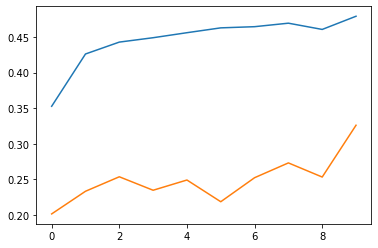

In [ ]:
# Отобразим график обучения модели
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

In [ ]:
processImage(modelL, 5, num_classes)

NameError: ignored

# Unet модель НС для Сегментации

In [ ]:
# Unet делать не обязательно, если сделал Unet Plus

# Unet Plus модель НС для Сегментации

In [ ]:
# Unet Plus делать не обязательно, если сделал Unet

# PSPNet модель НС для Сегментации